# Prepare Data

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations

C:\Users\Quibix\AppData\Local\Temp\ipykernel_3708\2132204403.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
transaction_df = pd.read_csv('prostateSurvival.csv')
transaction_df

,rownames,grade,stage,ageGroup,survTime,status
0,1,mode,T1c,80+,18,0
1,2,mode,T1ab,75-79,23,0
2,3,poor,T1c,75-79,37,0
3,4,mode,T2,70-74,27,0
4,5,mode,T1c,70-74,42,0
...,...,...,...,...,...,...
14289,14290,mode,T2,75-79,4,0
14290,14291,mode,T1c,75-79,11,0
14291,14292,mode,T2,70-74,8,0
14292,14293,mode,T2,75-79,6,0


In [4]:
ranges = [0, 30, 60, 90, 120, 130]
# Define labels for the categories
labels = ['LessMonth', 'TwoMonths', 'ThreeMonths', 'FourMonths', 'FiveMonths']

transaction_df['survive_time'] = pd.cut(transaction_df['survTime'], bins=ranges, labels=labels, right=False)

transaction_df = transaction_df.drop('survTime', axis=1)

In [5]:
# 0, (censored), 1 (death from prostate cancer), and 2 (death from other causes)

status_mapping = {0: 'censored', 1: 'death from prostate cancer', 2: 'death from other causes'}

# Replace numerical values with their meanings
transaction_df['status'] = transaction_df['status'].replace(status_mapping)


In [6]:
transaction_df = transaction_df.drop('rownames', axis=1)
transaction_df

,grade,stage,ageGroup,status,survive_time
0,mode,T1c,80+,censored,LessMonth
1,mode,T1ab,75-79,censored,LessMonth
2,poor,T1c,75-79,censored,TwoMonths
3,mode,T2,70-74,censored,LessMonth
4,mode,T1c,70-74,censored,TwoMonths
...,...,...,...,...,...
14289,mode,T2,75-79,censored,LessMonth
14290,mode,T1c,75-79,censored,LessMonth
14291,mode,T2,70-74,censored,LessMonth
14292,mode,T2,75-79,censored,LessMonth


In [7]:
transaction_df['item_list'] = transaction_df.apply(lambda row: ','.join(map(str, row)), axis=1)
transaction_df = transaction_df.drop('grade', axis=1)
transaction_df = transaction_df.drop('stage', axis=1)
transaction_df = transaction_df.drop('ageGroup', axis=1)
transaction_df = transaction_df.drop('status', axis=1)
transaction_df = transaction_df.drop('survive_time', axis=1)

trans_df = transaction_df.item_list.str.split(',')
trans_df
trans_df

0           [mode, T1c, 80+, censored, LessMonth]
1        [mode, T1ab, 75-79, censored, LessMonth]
2         [poor, T1c, 75-79, censored, TwoMonths]
3          [mode, T2, 70-74, censored, LessMonth]
4         [mode, T1c, 70-74, censored, TwoMonths]
                           ...                   
14289      [mode, T2, 75-79, censored, LessMonth]
14290     [mode, T1c, 75-79, censored, LessMonth]
14291      [mode, T2, 70-74, censored, LessMonth]
14292      [mode, T2, 75-79, censored, LessMonth]
14293    [mode, T2, 75-79, censored, ThreeMonths]
Name: item_list, Length: 14294, dtype: object

df.index.rename('TID', inplace=True)
df


In [8]:
trans_df[3]

['mode', 'T2', '70-74', 'censored', 'LessMonth']

# Functions to be used

In [9]:
from itertools import combinations

In [10]:
def create_candidate_1(X):
    """
    create the 1-item candidate,
    it's basically creating a frozenset for each unique item
    and storing them in a list
    """
    c1 = []
    for transaction in X:
        for t in transaction:
            t = frozenset([t])
            if t not in c1:
                c1.append(t)
    return c1

In [11]:
def create_freq_item(X, ck, min_support):

    item_count = {}
    for transaction in X:
        for item in ck:
            if item.issubset(transaction):
                if item not in item_count:
                    item_count[item] = 1
                else:
                    item_count[item] += 1

    n_row = X.shape[0]
    freq_item = []
    item_support = {}

    for item in item_count:
        support = item_count[item] / n_row
        if support >= min_support:
            freq_item.append(item)

        item_support[item] = support
#     print("item_supp", item_support)
#     print("freq_item", freq_item)
    return freq_item, item_support

In [12]:
def create_candidate_k(freq_item, k):
    ck = []

    if k == 0:
        for f1, f2 in combinations(freq_item, 2):
            item = f1 | f2
            ck.append(item)
    else:
        for f1, f2 in combinations(freq_item, 2):
            intersection = f1 & f2
            if len(intersection) == k:
                item = f1 | f2
                if item not in ck:
                    ck.append(item)
#     print(f"c{k}: {ck}")
    return ck

In [13]:
def compute_conf(freq_items, item_support_dict, freq_set, subsets, min_confidence):
    rules = []
    right_hand_side = []

    for rhs in subsets:
        lhs = freq_set - rhs
        conf = item_support_dict[freq_set] / item_support_dict[lhs]
        if conf >= min_confidence:
            lift = conf / item_support_dict[rhs]
            rules_info = lhs, rhs, conf, lift
            rules.append(rules_info)
            right_hand_side.append(rhs)

    return rules, right_hand_side

In [14]:
def create_rules(freq_items, item_support_dict, min_confidence):

    association_rules = []

    for idx, freq_item in enumerate(freq_items[1:(len(freq_items) - 1)]):
        for freq_set in freq_item:

            subsets = [frozenset([item]) for item in freq_set]
            rules, right_hand_side = compute_conf(freq_items, item_support_dict,
                                                  freq_set, subsets, min_confidence)
            association_rules.extend(rules)

            if idx != 0:
                k = 0
                while len(right_hand_side[0]) < len(freq_set) - 1:
                    ck = create_candidate_k(right_hand_side, k = k)
                    rules, right_hand_side = compute_conf(freq_items, item_support_dict,
                                                          freq_set, ck, min_confidence)
                    association_rules.extend(rules)
                    k += 1

    return association_rules

In [15]:
def filter_rules(association_rules, min_confidence):
    filtered_rules = []
    for rule in association_rules:
        if rule[2] >= min_confidence:
            filtered_rules.append(rule)
    filtered_rules = sorted(filtered_rules, key=lambda x: x[2], reverse=True)
    return filtered_rules

In [16]:
import matplotlib.pyplot as plt

def visualize_supports_evolution(item_support_dict, freq_items):
    supports_evolution = []
    for freq_item_set in freq_items:
        supports = [item_support_dict[item] for item in freq_item_set]
        supports_evolution.append(supports)

    plt.figure(figsize=(10, 6))
    for i, supports in enumerate(supports_evolution):
        plt.plot(range(len(supports)), supports, marker='o', label=f"Iteration {i+1}")

    plt.xlabel('Item Index')
    plt.ylabel('Support')
    plt.title('Supports Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
import matplotlib.pyplot as plt

def plot_itemset_sizes(apriori_results, adaptive_apriori_results):
    apriori_sizes = [len(itemset) for itemset in apriori_results]
    adaptive_apriori_sizes = [len(itemset) for itemset in adaptive_apriori_results]

    iterations1 = range(1, len(apriori_results) + 1)
    iterations2 = range(1, len(adaptive_apriori_results) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations1, apriori_sizes, marker='o', label='Apriori classique')
    plt.plot(iterations2, adaptive_apriori_sizes, marker='o', label='Apriori adaptatif')

    plt.xlabel('Itérations')
    plt.ylabel('Taille moyenne des itemsets fréquents')
    plt.title('Taille moyenne des itemsets fréquents au fil des itérations')
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def plot_association_rule_quality(apriori_rules, adaptive_apriori_rules):

    apriori_confidences = [rule[2] for rule in apriori_rules]
    adaptive_apriori_confidences = [rule[2] for rule in adaptive_apriori_rules]

    apriori_lifts = [rule[3] for rule in apriori_rules]
    adaptive_apriori_lifts = [rule[3] for rule in adaptive_apriori_rules]

    plt.figure(figsize=(18, 6))


    plt.subplot(1, 2, 1)
    plt.boxplot([apriori_confidences, adaptive_apriori_confidences], labels=['Apriori classique', 'Apriori adaptatif'])
    plt.title('Confiance des règles d\'association')

    plt.subplot(1, 2, 2)
    plt.boxplot([apriori_lifts, adaptive_apriori_lifts], labels=['Apriori classique', 'Apriori adaptatif'])
    plt.title('Lift des règles d\'association')

    plt.tight_layout()
    plt.show()

In [19]:
def plot_convergence_min_support(min_support_history):
    iterations = range(1, len(min_support_history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, min_support_history, marker='o')

    plt.xlabel('Itérations')
    plt.ylabel('Support Minimum')
    plt.title('Convergence du Support Minimum')
    plt.grid(True)
    plt.show()

# Regular Apriori

In [20]:
def apriori(X, min_support=0.1):
    c1 = create_candidate_1(X)
    freq_item, item_support_dict = create_freq_item(X, c1, min_support)
    freq_items = [freq_item]

    k = 0
    while len(freq_items[k]) > 0:
        freq_item = freq_items[k]
        ck = create_candidate_k(freq_item, k)
        freq_item, item_support = create_freq_item(X, ck, min_support)
        freq_items.append(freq_item)
        item_support_dict.update(item_support)
        k += 1

    return freq_items, item_support_dict

In [21]:
freq_items1, item_support_dict1 = apriori(trans_df.to_numpy(), min_support = 0.05)
freq_items1

[[frozenset({'mode'}),
  frozenset({'T1c'}),
  frozenset({'80+'}),
  frozenset({'censored'}),
  frozenset({'LessMonth'}),
  frozenset({'T1ab'}),
  frozenset({'75-79'}),
  frozenset({'poor'}),
  frozenset({'TwoMonths'}),
  frozenset({'T2'}),
  frozenset({'70-74'}),
  frozenset({'death from other causes'}),
  frozenset({'ThreeMonths'}),
  frozenset({'66-69'}),
  frozenset({'FourMonths'}),
  frozenset({'death from prostate cancer'})],
 [frozenset({'T1c', 'mode'}),
  frozenset({'80+', 'mode'}),
  frozenset({'censored', 'mode'}),
  frozenset({'LessMonth', 'mode'}),
  frozenset({'80+', 'T1c'}),
  frozenset({'T1c', 'censored'}),
  frozenset({'LessMonth', 'T1c'}),
  frozenset({'80+', 'censored'}),
  frozenset({'80+', 'LessMonth'}),
  frozenset({'LessMonth', 'censored'}),
  frozenset({'T1ab', 'mode'}),
  frozenset({'75-79', 'mode'}),
  frozenset({'T1ab', 'censored'}),
  frozenset({'75-79', 'censored'}),
  frozenset({'LessMonth', 'T1ab'}),
  frozenset({'75-79', 'LessMonth'}),
  frozenset({'75-79

In [22]:
association_rules1 = create_rules(freq_items1, item_support_dict1, min_confidence = 0.01)
association_rules1

[(frozenset({'T1c'}),
  frozenset({'mode'}),
  0.7921210772312486,
  1.0304494610432715),
 (frozenset({'mode'}),
  frozenset({'T1c'}),
  0.32389879868947946,
  1.0304494610432717),
 (frozenset({'mode'}),
  frozenset({'80+'}),
  0.36093920640698945,
  0.9203112765575289),
 (frozenset({'80+'}),
  frozenset({'mode'}),
  0.7074562968248305,
  0.9203112765575289),
 (frozenset({'mode'}),
  frozenset({'censored'}),
  0.7466326902074991,
  1.0406989443028758),
 (frozenset({'censored'}), frozenset({'mode'}), 0.8, 1.040698944302876),
 (frozenset({'LessMonth'}),
  frozenset({'mode'}),
  0.7511690520051013,
  0.9771760492683763),
 (frozenset({'mode'}),
  frozenset({'LessMonth'}),
  0.4824353840553331,
  0.9771760492683762),
 (frozenset({'T1c'}),
  frozenset({'80+'}),
  0.35811261963053637,
  0.9131041357472148),
 (frozenset({'80+'}),
  frozenset({'T1c'}),
  0.2870139136639315,
  0.9131041357472148),
 (frozenset({'T1c'}),
  frozenset({'censored'}),
  0.7663031382150012,
  1.0681167291706706),
 (fro

In [23]:
as_rules1 = filter_rules(association_rules1, min_confidence=0.3)
as_rules1

[(frozenset({'T1ab', 'censored'}),
  frozenset({'mode'}),
  0.8670192670948244,
  1.127882544944796),
 (frozenset({'66-69', 'mode'}),
  frozenset({'censored'}),
  0.8623005877413938,
  1.2019234130839087),
 (frozenset({'66-69', 'censored'}),
  frozenset({'mode'}),
  0.8623005877413938,
  1.1217441391677725),
 (frozenset({'70-74', 'LessMonth', 'mode'}),
  frozenset({'censored'}),
  0.8603145235892691,
  1.1991551243476364),
 (frozenset({'LessMonth', 'T1ab', 'censored'}),
  frozenset({'mode'}),
  0.8524822695035461,
  1.1089717473865752),
 (frozenset({'75-79', 'T1ab'}),
  frozenset({'mode'}),
  0.8522522522522523,
  1.1086725239983342),
 (frozenset({'T1ab', 'TwoMonths'}),
  frozenset({'mode'}),
  0.8507614213197968,
  1.1067331412764085),
 (frozenset({'70-74', 'censored'}),
  frozenset({'mode'}),
  0.8433530906011855,
  1.0970958388290266),
 (frozenset({'70-74', 'LessMonth'}),
  frozenset({'censored'}),
  0.8390461997019375,
  1.1695101295504138),
 (frozenset({'ThreeMonths', 'censored'})

# Proposed Apriori

In [24]:
def calculate_adaptive_factor(item_support_dict):
    mean_support = sum(item_support_dict.values()) / len(item_support_dict)
    supports = list(item_support_dict.values())
    deviation_sum = sum((support - mean_support) ** 2 for support in supports)
    variance = deviation_sum / len(supports)
    std_dev = variance ** 0.5

    # Find the density of supports around the mean
    density = sum(1 / (1 + abs(support - mean_support) / std_dev) for support in supports)
    # Weight the density by the total number of supports
    weighted_density = density / len(supports)

    # Calculate the adaptive factor based on the weighted density
    adaptive_factor = 0.5 + 0.5 * weighted_density  # Scales the weighted density to be in [0.5, 1.0]
    return adaptive_factor

In [25]:
minsup_list = []
def apriori_propose(X, min_support=0.1, adaptive=True):
    c1 = create_candidate_1(X)
    freq_item, item_support_dict = create_freq_item(X, c1, min_support)
    freq_items = [freq_item]
    minsup_list.append(min_support)

    k = 0
    while len(freq_items[k]) > 0:
        freq_item = freq_items[k]
        ck = create_candidate_k(freq_item, k)
        
        # If adaptive thresholding is enabled, calculate the new min_support
        if adaptive:
            adaptive_factor = calculate_adaptive_factor(item_support_dict)
            min_support = min_support * adaptive_factor
            print("\nNew min_support:", min_support)

        freq_item, item_support = create_freq_item(X, ck, min_support)
        freq_items.append(freq_item)
        item_support_dict.update(item_support)
        minsup_list.append(min_support)
        k += 1
    print(minsup_list)
    return freq_items, item_support_dict

In [26]:
freq_items2, item_support_dict2 = apriori_propose(trans_df.to_numpy(), min_support = 0.05, adaptive=True)
print(freq_items2, "\n")


New min_support: 0.04076849637395848

New min_support: 0.033439983260647795

New min_support: 0.02806104746498109

New min_support: 0.02377565026621349

New min_support: 0.020171920854950395
[0.05, 0.04076849637395848, 0.033439983260647795, 0.02806104746498109, 0.02377565026621349, 0.020171920854950395]
[[frozenset({'mode'}), frozenset({'T1c'}), frozenset({'80+'}), frozenset({'censored'}), frozenset({'LessMonth'}), frozenset({'T1ab'}), frozenset({'75-79'}), frozenset({'poor'}), frozenset({'TwoMonths'}), frozenset({'T2'}), frozenset({'70-74'}), frozenset({'death from other causes'}), frozenset({'ThreeMonths'}), frozenset({'66-69'}), frozenset({'FourMonths'}), frozenset({'death from prostate cancer'})], [frozenset({'mode', 'T1c'}), frozenset({'80+', 'mode'}), frozenset({'censored', 'mode'}), frozenset({'mode', 'LessMonth'}), frozenset({'80+', 'T1c'}), frozenset({'censored', 'T1c'}), frozenset({'T1c', 'LessMonth'}), frozenset({'censored', '80+'}), frozenset({'80+', 'LessMonth'}), frozens

In [27]:
association_rules2 = create_rules(freq_items2, item_support_dict2, min_confidence = 0.01)
as_rules2 = filter_rules(association_rules2, min_confidence=0.3)
as_rules2

[(frozenset({'70-74', 'T1ab', 'censored'}),
  frozenset({'mode'}),
  0.9099378881987579,
  1.1837142495370445),
 (frozenset({'70-74', 'T1ab'}),
  frozenset({'mode'}),
  0.8991172761664564,
  1.1696380001386357),
 (frozenset({'75-79', 'T1ab', 'censored'}),
  frozenset({'mode'}),
  0.8887417218543046,
  1.1561407146146188),
 (frozenset({'T1ab', 'TwoMonths', 'censored'}),
  frozenset({'mode'}),
  0.8778359511343803,
  1.1419536845208256),
 (frozenset({'66-69', 'LessMonth', 'mode'}),
  frozenset({'censored'}),
  0.8741258741258741,
  1.2184061672116278),
 (frozenset({'T1ab', 'censored'}),
  frozenset({'mode'}),
  0.8670192670948244,
  1.127882544944796),
 (frozenset({'70-74', 'TwoMonths', 'censored'}),
  frozenset({'mode'}),
  0.8625954198473282,
  1.1221276784945131),
 (frozenset({'70-74', 'T1c', 'censored'}),
  frozenset({'mode'}),
  0.862547288776797,
  1.1220650660516507),
 (frozenset({'66-69', 'mode'}),
  frozenset({'censored'}),
  0.8623005877413938,
  1.2019234130839087),
 (frozense

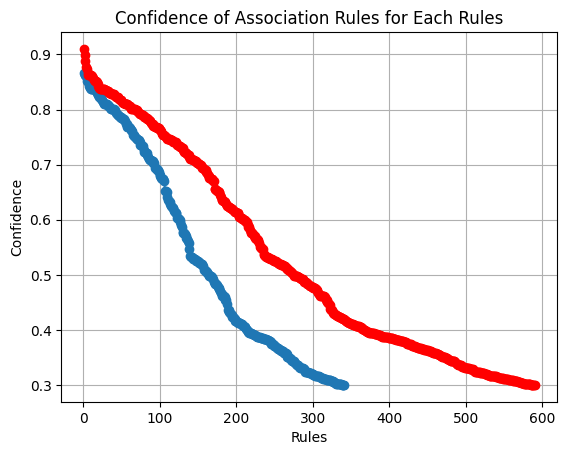

In [68]:
confidence_values1 = [rule[2] for rule in as_rules1]
confidence_values2 = [rule[2] for rule in as_rules2]

# Plotting
plt.plot(range(1, len(confidence_values1) + 1), confidence_values1, marker='o')
plt.plot(range(1, len(confidence_values2) + 1), confidence_values2, marker='o', color='red')
plt.xlabel('Rules')
plt.ylabel('Confidence')
plt.title('Confidence of Association Rules for Each Rules')
plt.grid(True)
plt.show()

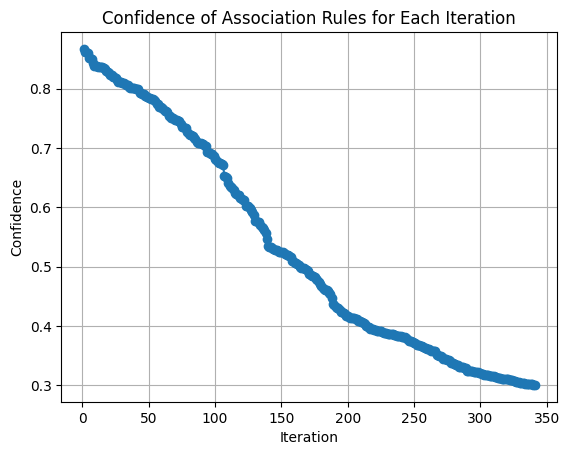

In [64]:
confidence_values = [rule[2] for rule in as_rules1]

# Plotting
plt.plot(range(1, len(confidence_values) + 1), confidence_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Confidence')
plt.title('Confidence of Association Rules for Each Iteration')
plt.grid(True)
plt.show()

In [29]:

# Fix the regularization factor nd how to get the best results either the case
# Graphe temps d'execution + graphe de distribution de confiance for each method
# Nombre de règles d'associations for each method
# Test sur d'autres datasets: pour prouver l'adaptation de l'algorithme
# Graphe de changement de minsup

# Visualisations

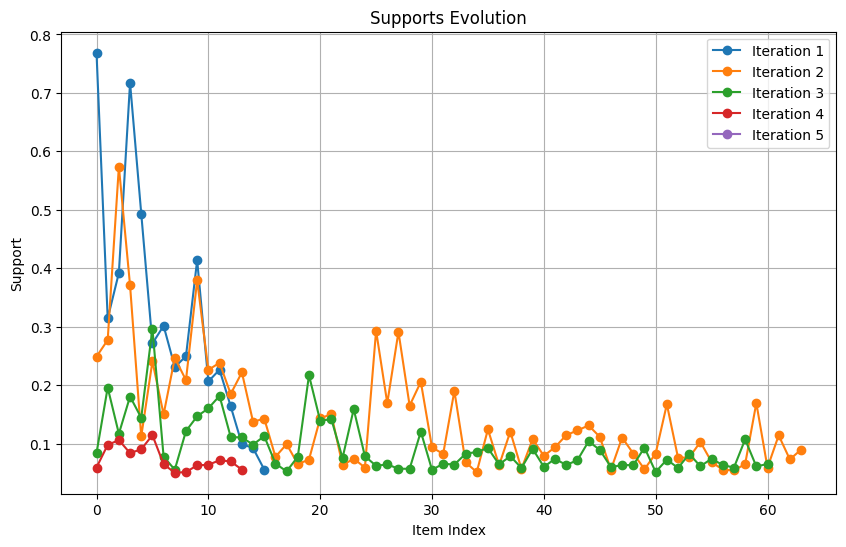

In [30]:
visualize_supports_evolution(item_support_dict1, freq_items1)

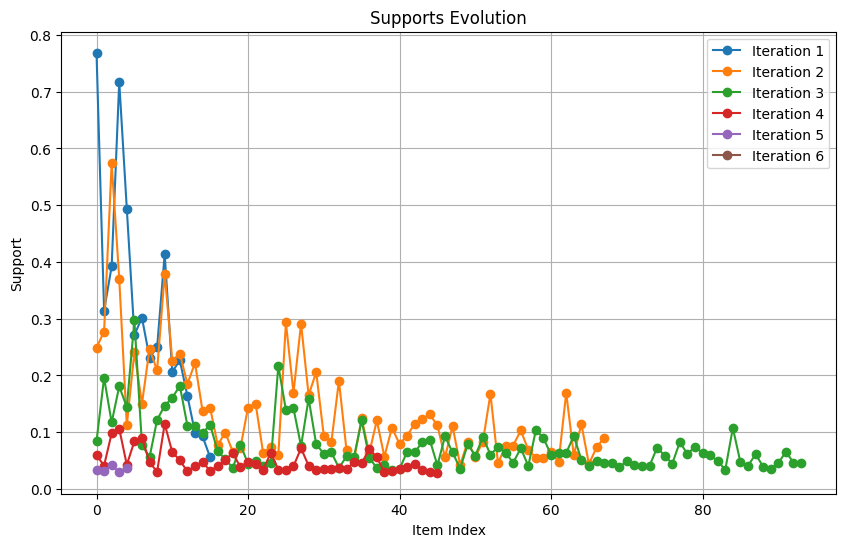

In [31]:
visualize_supports_evolution(item_support_dict2, freq_items2)

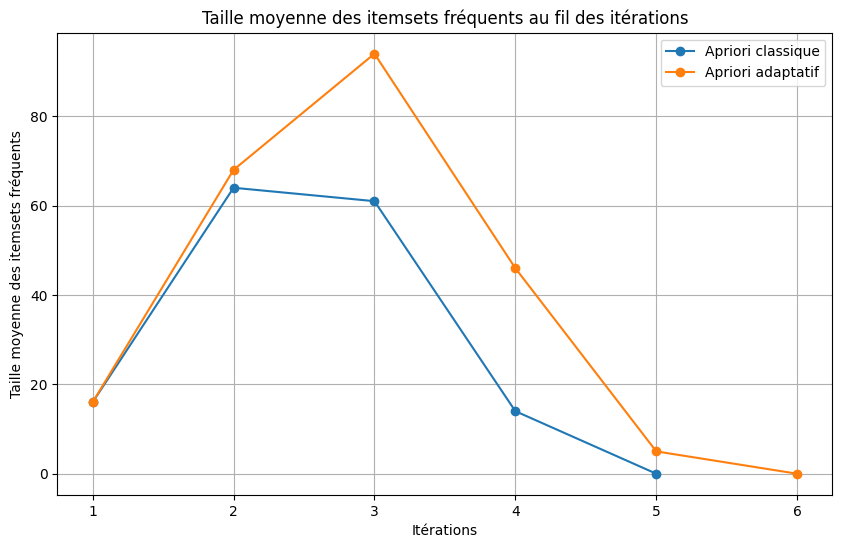

In [32]:
plot_itemset_sizes(freq_items1, freq_items2)

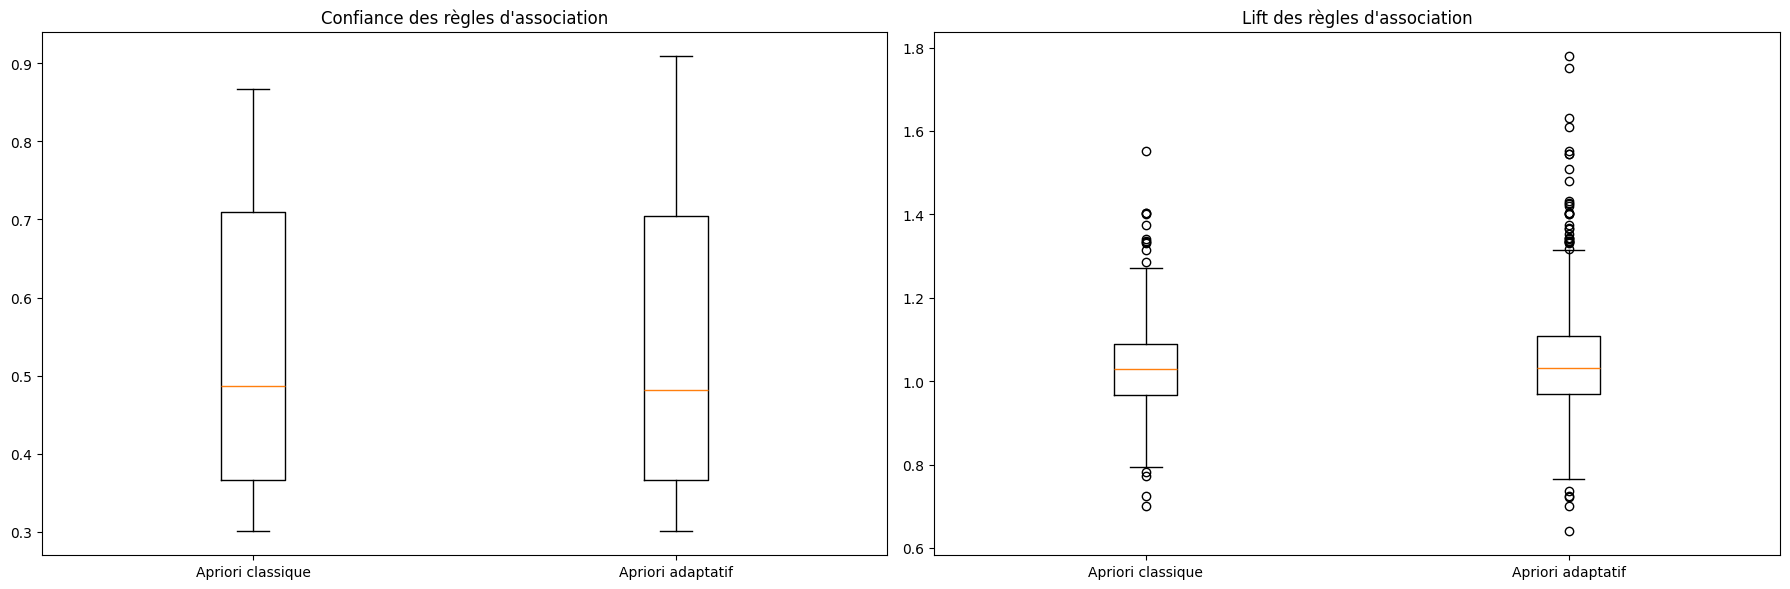

In [33]:
plot_association_rule_quality(as_rules1, as_rules2)

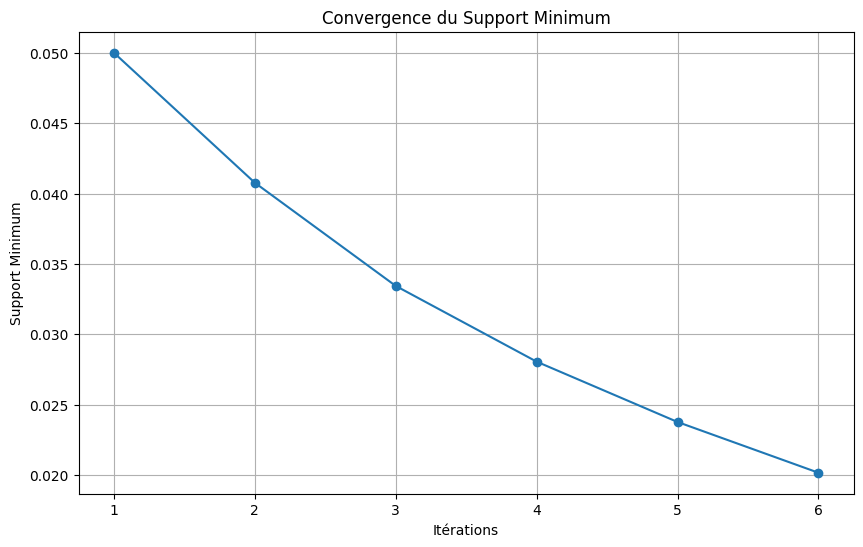

In [34]:
plot_convergence_min_support(minsup_list)